# Function Fitting Example:

#### <font color="blue"> by: Jeremy Meinke (feel free to contact me here on GitHub, LinkedIn, or email)

This details use of functions found within func_fitting.py, which contains my own custom set of functions for fitting other functions.  Allows for both GLS and noteably Bayesian analysis (which I at least consider to be a pretty cool and relatively quick code).
    
Also make sure to see the companion "analysis_example.ipynb" for mm astrononmy functions that would benefit from function fits.


In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from cycler import cycler
import time
import gc

from analysis_code import func_fitting

###My personal matplotlib preferences
marker_cycle=["o","^","s","d","X","2","h","v",">"]
color_cycle=["k","b","r","c","orange","m","lime","grey","lavender"]
mpl.rcParams["axes.prop_cycle"] = cycler(color=color_cycle + color_cycle[::-1], marker=marker_cycle*2)

print("Last time run: %s"%time.asctime())

Last time run: Fri Feb  3 15:09:02 2023


(admittedly this isn't a great example for the fit quality itself, but for the fit options)

To start, we'll define a simple polynomial function to do different fitting with.  We'll also define an alternate way to write it in order to showcase the non-linear approach:

In [2]:
def simple_func(x, a, b, c):
    return a*x**2 + b*x + c

def simple_func_alt(x, d, e, f):
    return d*x + e*(x-f)**2

###note that these two equations will both produce 2nd order polynomials, just defined in different ways

###Define "True values", in a way that ensures both functions produce the same results
a_true = e_true = 1
f_true = 5
c_true = e_true * f_true**2
b_true = 1
d_true = b_true + 2*e_true*f_true

###Quick way to print all of them:
for text in ["a", "b", "c", "d", "e", "f"]:
    exec("print('%s_true: ', %s_true)"%(text, text))

a_true:  1
b_true:  1
c_true:  25
d_true:  11
e_true:  1
f_true:  5


Now, let's see what they look like.  They should be identical:

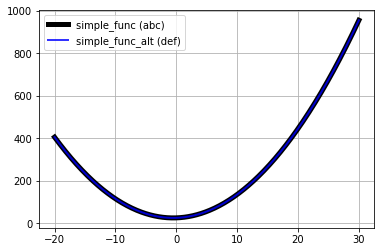

In [3]:
x_range = np.arange(-20, 30.01, 0.1)
plt.plot(x_range, simple_func(x_range, a_true, b_true, c_true), label="simple_func (abc)", marker="",linewidth=5)
plt.plot(x_range, simple_func_alt(x_range, d_true, e_true, f_true), label="simple_func_alt (def)", marker="", linewidth=2, alpha=0.8)
plt.legend()
plt.grid()
plt.show()

#### Generate some fake data (and noise):

x data: 
 [  4.1  18.2  19.7   8.7  26.6  17.9  22.9  11.7  20.9   0.9 -15.8  20.6
   2.9  25.6  -5.8]

 y data: 
 [ 48.99630682 367.89189438 450.33628884 111.85195091 764.56108317
 369.67084012 564.82733682 149.70997828 471.63291564  48.06246573
 255.95113843 461.47875444  32.49068004 715.2686136   67.84270713]


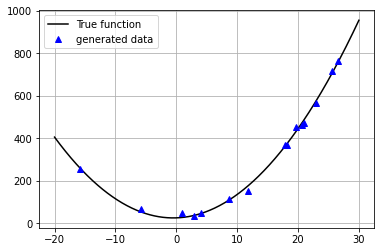

In [4]:
def gen_data(x_range, N=15, noise_sigma=10):
    x_data = np.random.choice(x_range, N, replace=False)
    y_data = simple_func(x_data, a_true, b_true, c_true) + np.random.normal(0, noise_sigma, size=N)
    return x_data, y_data

noise_sigma = 10
x_data, y_data = gen_data(x_range, noise_sigma=noise_sigma)

print("x data: \n", x_data)
print("\n y data: \n", y_data)


plt.plot(x_range, simple_func(x_range, a_true, b_true, c_true), label="True function", marker="")
plt.plot(x_data, y_data, label="generated data", linestyle="")
plt.legend()
plt.grid()
plt.show()

Now that we have our fake data, we can attempt to fit it!  We can do this a handful of ways, namely:
- scipy.optimize.curve_fit: A good method to use in most simple or quick cases.
- func_fitting.func_fit(method="GLS"): Generalized least squares implementation in my custom func_fit code
- func_fitting.func_fit(method="BE"): Bayesian estimation use of func_fitting.  Most helpful in non-linear cases (works for both simple_func and simple_func_alt)

So working through these types in order:

simple_func curve_fit best fit:  [ 1.00327447  0.80082    27.52684643] 
 simple_func cov: 
 [[ 3.05012359e-04 -4.44377509e-03 -3.45841912e-02]
 [-4.44377509e-03  1.10789474e-01 -4.59430131e-02]
 [-3.45841912e-02 -4.59430131e-02  1.71527175e+01]]
simple_func_alt curve_fit best fit:  [11.31119223  1.00327448  5.23803433] 
 simple_func_alt cov: 
 [[ 6.11061568e-01 -9.44862264e-03  3.14621875e-01]
 [-9.44862264e-03  3.05012387e-04 -4.08670697e-03]
 [ 3.14621875e-01 -4.08670697e-03  1.74531183e-01]]


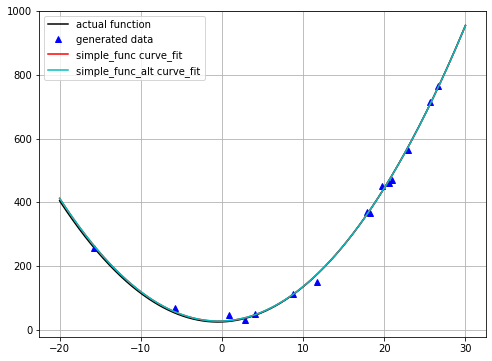

In [5]:
###Curve fits
simple_func_popt, simple_func_popc = curve_fit(simple_func, x_data, y_data, sigma=noise_sigma*np.ones_like(x_data), absolute_sigma=True)
print("simple_func curve_fit best fit: ", simple_func_popt, "\n simple_func cov: \n", simple_func_popc)
simple_func_alt_popt, simple_func_alt_popc = curve_fit(simple_func_alt, x_data, y_data, sigma=noise_sigma*np.ones_like(x_data), absolute_sigma=True)
print("simple_func_alt curve_fit best fit: ", simple_func_alt_popt, "\n simple_func_alt cov: \n", simple_func_alt_popc)

plt.figure(figsize=(8,6))
plt.plot(x_range, simple_func(x_range, a_true, b_true, c_true), label="actual function", marker="")
plt.plot(x_data, y_data, label="generated data", linestyle="")
plt.plot(x_range, simple_func(x_range, *simple_func_popt), label="simple_func curve_fit", marker="")
plt.plot(x_range, simple_func_alt(x_range, *simple_func_alt_popt), label="simple_func_alt curve_fit", marker="")
plt.legend()
plt.grid()
plt.show()


There should be a small but noticeable difference between the curve_fit results and the true function, while the curve_fits of each simple_func vs simple_func_alt shouldn't be noticeably different.

Now for func_fit GLS:

In [6]:
## func_fitting.func_fit() setup
## the fit_range attribute isn't needed for the method="GLS", but will become relevant for method="BE"
a_param = func_fitting.FuncParam("a", "a", np.arange(0, 3.01, 0.02), is_linear=True)
b_param = func_fitting.FuncParam("b", "b", np.arange(0, 3.01, 0.02), is_linear=True)
c_param = func_fitting.FuncParam("c", "c", np.arange(-30., 50.01, 0.2), is_linear=True)

## Note this asks for variance/covariance (for when passing 1d or 2d arrays)
gls_fit, gls_cov = func_fitting.func_fit(simple_func, x_data, y_data, [a_param, b_param, c_param], noise_sigma**2, method="GLS")
print("simple_func GLS best fit: ", gls_fit, "\n simple_func GLS cov: \n", gls_cov)


-----GLS Fitting-----
simple_func GLS best fit:  {'a': 1.0032744748095617, 'b': 0.8008199478838451, 'c': 27.52684597184237} 
 simple_func GLS cov: 
 [[ 3.05012389e-04 -4.44377566e-03 -3.45841885e-02]
 [-4.44377566e-03  1.10789483e-01 -4.59430419e-02]
 [-3.45841885e-02 -4.59430419e-02  1.71527165e+01]]


This is identical to curve_fit's fit for simple_func, since here they both use the least squares method! 

So what about the BE version?

In [7]:
###We'll also pass quick_corner_plot=True (it's default), showing us the corner plot
simple_func_be_fit, simple_func_be_cov, simple_func_be_1d_bnds, b_bnds, marg_dists = func_fitting.func_fit(simple_func, x_data, y_data, [a_param, b_param, c_param], noise_sigma**2, method="BE", MemoryOverride=False, quick_corner_plot=True)
print("simple_func BE best fit: ", simple_func_be_fit, "\n simple_func BE cov: \n", simple_func_be_cov)

-----BE Fitting-----
No corner plot yet...
simple_func BE best fit:  {'a': 1.0, 'b': 0.8, 'c': 27.399999999999793} 
 simple_func BE cov: 
 [[ 3.04941281e-04 -4.19437511e-03 -3.43114152e-02]
 [-4.19437511e-03  1.05211456e-01 -4.26932847e-02]
 [-3.43114152e-02 -4.26932847e-02  1.71691991e+01]]


Notice how chances are the "c" parameter is poorly contrained.  We get similar results to the curve_fit and GLS results above, but are limited by the fit_range (both range and resolution) capable of being passed.  So what's the benefit here?  Non-linear relations, such as with simple_func_alt: 

(and manipulation of priors and posterior distributions, to be shown later below)

In [8]:
d_param = func_fitting.FuncParam("d", "d", np.arange(-11., 33.01, 0.1), is_linear=True)
e_param = func_fitting.FuncParam("e", "e", np.arange(0, 3.01, 0.01), is_linear=True)
f_param = func_fitting.FuncParam("f", "f", np.arange(-0., 10.01, 0.1), is_linear=False)     ###Note that f is not linear here
simple_func_alt_be_fit, simple_func_alt_be_cov, simple_func_alt_be_1d_bnds, b_bnds, marg_dists = func_fitting.func_fit(simple_func_alt, x_data, y_data, [d_param, e_param, f_param], noise_sigma**2, method="BE", MemoryOverride=False, quick_corner_plot=True)
print("simple_func_alt BE best fit: ", simple_func_alt_be_fit, "\n simple_func_alt BE cov: \n", simple_func_alt_be_cov)

-----BE Fitting-----
No corner plot yet...
simple_func_alt BE best fit:  {'d': 11.199999999999921, 'e': 1.0, 'f': 5.2} 
 simple_func_alt BE cov: 
 [[ 6.40651807e-01 -9.55888076e-03  3.28984511e-01]
 [-9.55888076e-03  3.20184513e-04 -4.19576613e-03]
 [ 3.28984511e-01 -4.19576613e-03  1.81913441e-01]]


This time we compare to the simple_func_alt curve_fit from a few blocks above.  They again should be very similar, but affected a bit by the parameter's fit_ranges resolution and limits.  Feel free to adjust these some and see how it changes.  I placed a basic array size check (via MemoryOverride=False) to try to ensure I never bricked my memory (*Cough* totally out of precaution and not because it actually happened multiple times...)


Now, about priors:  Say one parameter is difficult to ascertain, has minimal impact, and various papers simply quote it as a constant to say good enough.  Well, instead of just also calling it a constant while citing those papers that cite those other papers that cite some other papers... we can invoke some sort of prior, such as a Gaussian prior to say we expect it to be near that value, but allow some uncertainty in case it affects our other variables that we care about more.

Here, we'll do it for parameter "d" and try again:

In [9]:
d_param = func_fitting.FuncParam("d", "d", *func_fitting.gaussian_range_prior(d_true, 0.5, 0.01), is_linear=True)
## It also allows us the ability in this case to zoom in on our other parameters a bit more:
e_param = func_fitting.FuncParam("e", "e", np.arange(0, 3.01, 0.01), is_linear=True)
f_param = func_fitting.FuncParam("f", "f", np.arange(-0., 10.01, 0.05), is_linear=False)     ###Note that f is not linear here

simple_func_alt_dprior_be_fit, simple_func_alt_dprior_be_cov, simple_func_alt_dprior_be_1d_bnds, b_bnds, marg_dists = func_fitting.func_fit(simple_func_alt, x_data, y_data, [d_param, e_param, f_param], noise_sigma**2, method="BE", MemoryOverride=False, quick_corner_plot=True)
print("simple_func_alt (d prior) BE best fit: ", simple_func_alt_dprior_be_fit, "\n simple_func_alt (d prior) BE cov: \n", simple_func_alt_dprior_be_cov)

-----BE Fitting-----
At least 1 Prior Weight Provided 

No corner plot yet...
simple_func_alt (d prior) BE best fit:  {'d': 11.08, 'e': 1.0, 'f': 5.1000000000000005} 
 simple_func_alt (d prior) BE cov: 
 [[ 0.17990058 -0.00267661  0.092362  ]
 [-0.00267661  0.00024128 -0.00045043]
 [ 0.092362   -0.00045043  0.0604382 ]]
